M2 project : Convolutions and character embeddings
======================

The project aims to predict the language from which a character sequence comes from. This is done with surnames and it involves a dozen of languages.

Data download & description
---------------------

In [ ]:
from urllib.request import urlretrieve

urlretrieve('http://www.linguist.univ-paris-diderot.fr/~bcrabbe/datasets/name2lang.train','name2lang.train')
urlretrieve('http://www.linguist.univ-paris-diderot.fr/~bcrabbe/datasets/name2lang.valid','name2lang.valid')

#Prints the beginning of the valid set
istream = open('name2lang.valid')
for idx, line in enumerate(istream):
  print(line.strip())
  if idx >=300:
    break
istream.close()

Barros, Portuguese
Campos, Portuguese
D'cruz, Portuguese
Henriques, Portuguese
Machado, Portuguese
Silva, Portuguese
Torres, Portuguese
Ahearn, Irish
Aonghus, Irish
Brady, Irish
Cearbhall, Irish
Flann, Irish
Kavanagh, Irish
Maguire, Irish
Mcmahon, Irish
Mcneil, Irish
Monahan, Irish
Muirchertach, Irish
Mullen, Irish
O'Connell, Irish
O'Grady, Irish
O'Hara, Irish
O'Mahony, Irish
Rory, Irish
Shannon, Irish
Sioda, Irish
Tadhgan, Irish
Abel, Spanish
Agramunt, Spanish
Aldana, Spanish
Alfaro, Spanish
Aquino, Spanish
Arena, Spanish
Blanco, Spanish
Bustos, Spanish
Cardona, Spanish
Castellano, Spanish
Del olmo, Spanish
Etxeberria, Spanish
Garrastazu, Spanish
Hierro, Spanish
Loyola, Spanish
Maradona, Spanish
Mas, Spanish
Nieves, Spanish
Ortega, Spanish
Pelaez, Spanish
Robles, Spanish
Roldan, Spanish
Suero, Spanish
Tomas, Spanish
Torres, Spanish
Tos, Spanish
Ubina, Spanish
Urena, Spanish
Valdez, Spanish
Varela, Spanish
Vasquez, Spanish
Villa, Spanish
Villaverde, Spanish
Zavala, Spanish
Pham, Vietna

First exercise : data preprocessing (3pts)
---
The first exercise amounts to create encodings from integers to strings and from strings to integers.

In [ ]:
def vocabulary(filename,char_vocab,pad_token='<pad>'):
    """
    Args:
      filename (str)    : the name of the file
      char_vocab (bool) : selects if we extact char symbols or language codes
      pad_token(str)    : the value of the pad symbol
    """
    #char_vocab is a boolean flag that tells if we extract char symbols or language codes

    #TODO : return the two encoding maps idx2sym and sym2idx as a couple
    idx2sym = set()
    # read file
    istream = open(filename)
    for line in istream:
      if line and not line.isspace():
        word,lang = line.split(',')
        # update encoding map idx2sym
        idx2sym.update(list(word.strip()) if char_vocab else [lang.strip()])
    # close file
    istream.close()
    if char_vocab:
        # add the padding token for char map
        idx2sym.add(pad_token)
    # create encoding map sym2idx
    sym2idx = {sym:i for i, sym in enumerate(idx2sym)}

    return (idx2sym, sym2idx)

In [ ]:
def pad_sequence(sequence,pad_size,pad_token):

    #returns a list with additional pad tokens to match pad_size if needed
    if len(sequence) < pad_size:
        return sequence + [pad_token] * (pad_size - len(sequence))
    return sequence[:pad_size]

def code_sequence(charseq,encodingmap):
  #we ignore chars not seen in train set
  #charseq is a sequence of chars
  return [encodingmap[c] for c in charseq if c in encodingmap]

def decode_sequence(idxseq,decodingmap):
  #idxseq is a list of integers
  return [decodingmap[idx] for idx in idxseq]

Second exercise : data generator (2pt)
------------

The data generator aims to deliver efficiently well formed batches of data to the model.

In [ ]:
def read_dataset(filename, input_symbols):
    #reads from a raw datafile, either the surnmaes if input_symbols is True otherwise it reads the language
    symbols = []
    istream = open(filename)
    for line in istream:
      if line and not line.isspace():
        word,lang = line.split(',')
        symbol = list(word.strip()) if input_symbols else lang.strip()
        symbols.append(symbol)
    istream.close()
    return symbols

In [ ]:
from random import shuffle

class DataGenerator:

      def __init__(self,filename, parentgenerator = None,pad_token='<pad>'):

           self.pad_token = pad_token
           if parentgenerator is not None: #Reuse the encodings of the parent if specified
             self.input_idx2sym,self.input_sym2idx     = parentgenerator.input_idx2sym,parentgenerator.input_sym2idx
             self.output_idx2sym,self.output_sym2idx   = parentgenerator.output_idx2sym,parentgenerator.output_sym2idx
           else:
             #######################################
             self.input_idx2sym,self.input_sym2idx     = vocabulary(filename, True, pad_token) ### fill it !
             self.output_idx2sym,self.output_sym2idx   = vocabulary(filename, False, pad_token) ### fill it !
             ####################################
           self.X = read_dataset(filename,True)
           self.Y = read_dataset(filename,False)

      def generate_batches(self,batch_size):

              assert(len(self.X) == len(self.Y))

              N     = len(self.X)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.X[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.X[idx]) for idx in batch_idxes)
                 Xpad        = [pad_sequence(self.X[idx],batch_len,self.pad_token)  for idx in batch_idxes]
                 seqX        = [code_sequence(x,self.input_sym2idx) for x in Xpad]
                 seqY        = [self.output_sym2idx[self.Y[idx]] for idx in batch_idxes]

                 assert(len(seqX) == len(seqY))
                 yield (seqX,seqY)
                 bstart += batch_size

To answer the question \< Why these 2 lines(Data ordering) make sense?\>: When we generate batches, the maximum length of the sequence in each batch is usually determined by the longest sequence, so we want to reduce the number of \< pad \> by sorting and placing data of similar lengths in the same batch, which speeds up the training as well as reduces the waste of memory.

Third exercise : Implement the word embedding submodule (5pts)
-----
This exercise amounts to implement a pytorch submodule that takes as input a sequence of char indexes and outputs the word embedding corresponding for the sequence.

The module contains no training method and is meant to be used in a larger network. Its use is quite similar to `nn.Embedding`




In [ ]:
import torch
import torch.nn as nn

class CharConvolution(nn.Module):

      def __init__(self,windowK,chars_vocab_size,input_embedding_size,output_embedding_size,padding_idx = None):

          super(CharConvolution, self).__init__()
          #####################################
          #Initialize and allocate an embeddings class and the Conv1d class
          #####################################
          # create embedding layer
          self.embeddings = nn.Embedding(num_embeddings=chars_vocab_size, embedding_dim=input_embedding_size, padding_idx=padding_idx)
          # create convolutional layer
          self.conv1d = nn.Conv1d(in_channels=input_embedding_size, out_channels=output_embedding_size, kernel_size=windowK)

      def forward(self,xinput):
          #####################################
          #Implement the forward method, taking an input of the form [batch,seq]
          #and return the max pooled result
          ######################################
          # embedding layer
          x = self.embeddings(xinput) # [batch_size, seq_len, input_embedding_size]
          # adjust dimensions to fit Conv1d input
          x = x.permute(0, 2, 1) # [batch_size, input_embedding_size, seq_len]
          # Conv1d layer
          x = self.conv1d(x) # [batch_size, output_embedding_size, new_seq_len]
          # using activation function
          x = nn.functional.relu(x)
          # max pooling
          x = torch.max(x, dim=2)[0] # [batch_size, output_embedding_size]
          return x

Fourth Exercise : predict the target language (10pts)
-------
In this exercise, we aim to predict the target language from a word char embedding. You will implement for the `LanguageIdentifier` class:
* A forward function: the function takes as input a char index tensor and returns a vector of prediction for each word
* A train function: the function trains the model on the full dataset (with early stopping)
* A predict function: the function takes a test corpus (a list of words)
and predicts the language. The function outputs its results in textual form. Each word is printed on the same line as its predicted class.

Once implemented you are expected to search for hyperparameters in the main program.






In [ ]:
import torch.optim as optim
from tqdm import tqdm

class LanguageIdentifier(nn.Module):

    def __init__(self,datagenerator,window_size,char_embedding_size,word_embedding_size):
      super(LanguageIdentifier, self).__init__()
      invocab_size   = len(datagenerator.input_idx2sym)
      outvocab_size  = len(datagenerator.output_idx2sym)
      pad_idx        = datagenerator.input_sym2idx[datagenerator.pad_token]
      self.charE     = CharConvolution(window_size,invocab_size,char_embedding_size,word_embedding_size,padding_idx = pad_idx)
      self.output    = nn.Linear(word_embedding_size,outvocab_size)

      self.train_loss = []
      self.val_loss = []

    def load(self,filename):
        self.load_state_dict(torch.load(filename))


    def forward(self,xinput):
      #########################
      #takes as input a tensor of the form [batch,seq]
      #and returns a vector of predictions for the language
      x = self.charE(xinput) # [batch, word_embedding_size]
      x = self.output(x) # [batch, outvocab_size]
      return x # nn.functional.softmax(x, dim=1) - thanks for the cross_entropy loss, we do not need softmax

    def train(self,traingenerator,validgenerator,epochs,batch_size,device='cpu',learning_rate=0.001):

      self.minloss = 10000000 #the minimal validation loss found so far for an epoch
      ###########################
      #TODO Implement the training function, save the model with minimum loss

      optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
      self.early_stop_counter = 0
      patience = 3
      super().train()

      self.to(device)

      for epoch in range(epochs):
        epoch_loss = [] # will contain the loss for each batch of the current epoch
        for x, y in traingenerator.generate_batches(batch_size):
            optimizer.zero_grad() # make sure the gradient is reinitialised to zero
            x, y = torch.LongTensor(x).to(device), torch.LongTensor(y).to(device)
            # compute the prediction
            prediction = self.forward(x)
            # compute the loss
            batch_loss = nn.functional.cross_entropy(prediction, y)
            # call 'backward' on the loss
            batch_loss.backward()
            # update the parameters
            optimizer.step()

            # store each batch_loss in epoch_loss
            epoch_loss.append(batch_loss.item())
        self.train_loss.append(sum(epoch_loss) / len(epoch_loss))
        print(f"-- END OF EPOCH {epoch+1}.")
        print(f"Average loss: {self.train_loss[-1]}.")
        # validation
        self.validate(validgenerator, batch_size, device,save_min_model=True)
        # early stopping
        if self.early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    def predict(self,datagenerator,batch_size,device):
        ##########################
        #TODO implement a prediction function that returns the class with highest score for each word in the batch
        prediction = []
        for (seqX,seqY) in datagenerator.generate_batches(batch_size):
              with torch.no_grad():
                  X    = torch.LongTensor(seqX).to(device)
                  Y    = torch.LongTensor(seqY).to(device)
                  Yhat = self.forward(X)
                  prediction.extend(torch.argmax(Yhat,dim=1))
        return prediction


    def validate(self,datagenerator,batch_size,device='cpu',save_min_model=False):
        #This function cannot be modified

        batch_accurracies = []
        batch_losses      = []
        batch_sizes       = []

        device    = torch.device(device)
        loss_fnc  = nn.CrossEntropyLoss()

        for (seqX,seqY) in datagenerator.generate_batches(batch_size):

              with torch.no_grad():
                  X    = torch.LongTensor(seqX).to(device)
                  Y    = torch.LongTensor(seqY).to(device)

                  Yhat = self.forward(X)
                  loss = loss_fnc(Yhat,Y)
                  Ypred = torch.argmax(Yhat,dim=1)
                  acc   = float(torch.sum(Ypred == Y))

                  batch_losses.append(loss.item())
                  batch_accurracies.append(acc)
                  batch_sizes.append(len(Y))

        valid_loss = sum(batch_losses) / len(batch_losses)
        # save validation loss
        self.val_loss.append(valid_loss)
        print('[valid]  mean loss = %f, mean acc = %f'%( valid_loss , sum(batch_accurracies)/sum(batch_sizes)))
        if valid_loss < self.minloss:
            self.minloss = valid_loss
            torch.save(self.state_dict(), 'names_params.pt')
            # Early Stopping check
            self.early_stop_counter = 0 # if loss decrease, we reset the counter
        else:
            self.early_stop_counter += 1 # if loss continue creasing, the counter plus one


Main program. You are expected to search for hyperparameters:

In [ ]:
traing = DataGenerator('name2lang.train')
validg = DataGenerator('name2lang.valid',parentgenerator=traing)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LanguageIdentifier(traing,2,32,512)
model.train(traing,validg,30,128, device=device)

-- END OF EPOCH 1.
Average loss: 1.3490245745876643.
[valid]  mean loss = 1.543194, mean acc = 0.530139
-- END OF EPOCH 2.
Average loss: 1.0759004445995872.
[valid]  mean loss = 1.193304, mean acc = 0.614632
-- END OF EPOCH 3.
Average loss: 0.9037131497005778.
[valid]  mean loss = 1.072364, mean acc = 0.657908
-- END OF EPOCH 4.
Average loss: 0.7941861807361362.
[valid]  mean loss = 0.941689, mean acc = 0.699639
-- END OF EPOCH 5.
Average loss: 0.7132466751642115.
[valid]  mean loss = 0.870762, mean acc = 0.720762
-- END OF EPOCH 6.
Average loss: 0.6461254793593264.
[valid]  mean loss = 0.776886, mean acc = 0.753220
-- END OF EPOCH 7.
Average loss: 0.5952568752911147.
[valid]  mean loss = 0.768838, mean acc = 0.756311
-- END OF EPOCH 8.
Average loss: 0.5582371218877984.
[valid]  mean loss = 0.716087, mean acc = 0.768676
-- END OF EPOCH 9.
Average loss: 0.5274392901736451.
[valid]  mean loss = 0.687614, mean acc = 0.778465
-- END OF EPOCH 10.
Average loss: 0.5022875327528931.
[valid]  m

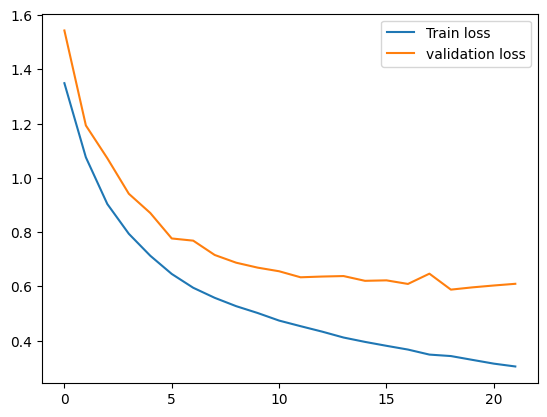

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.train_loss)
plt.plot(model.val_loss)
plt.legend(['Train loss','validation loss'])

plt.show()